In [ ]:
%%capture
!pip install --no-index --find-links=../input/aimo-pip -U transformers==4.45.2 vllm==0.6.3 
!pip install --no-index --find-links=../input/aimo-pip -U torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1
!pip uninstall -y pynvml
!pip install nvidia-ml-py
!pip install qwen-vl-utils


In [1]:
from huggingface_hub import snapshot_download
ss = snapshot_download('Qwen/Qwen2-VL-7B-Instruct')

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
!pip install pdf2image
!sudo apt-get install poppler-utils -y

import os
from pdf2image import convert_from_path

def convert_pdfs_to_images(pdf_directory, image_directory):
    # Create the output directory if it doesn't exist
    os.makedirs(image_directory, exist_ok=True)

    # Loop through all files in the specified directory
    for filename in os.listdir(pdf_directory):
        if filename.endswith('.pdf'):
            pdf_path = os.path.join(pdf_directory, filename)
            print(pdf_path)
            # Convert the PDF to images
            images = convert_from_path(pdf_path)

            # Save each image
            for i, image in enumerate(images):
                image_filename = f"{os.path.splitext(filename)[0]}_page_{i + 1}.png"
                image_path = os.path.join(image_directory, image_filename)
                image.save(image_path, 'PNG')
                print(f"Saved: {image_path}")

# Specify your directories
pdf_directory = '/kaggle/input/pdffiles/Jan to Mar/'  # Directory containing PDF files
image_directory = 'kaggle/working/images'  # Directory to save images

# Run the conversion
convert_pdfs_to_images(pdf_directory, image_directory)


In [3]:
import os
import base64
pdf_directory = '/kaggle/working/kaggle/working/images'
img_paths = []
for filename in os.listdir(pdf_directory):
    if filename.endswith('.png'):
        pdf_path = os.path.join(pdf_directory, filename)
        img_paths.append(pdf_path)



In [4]:
encod_images = []

for i in img_paths:
    with open(i, "rb") as f:
        encoded_image = base64.b64encode(f.read())
        encod_images.append(encoded_image)


In [ ]:
from transformers import AutoProcessor
from vllm import LLM, SamplingParams
from qwen_vl_utils import process_vision_info
from vllm.multimodal.utils import fetch_image

MODEL_PATH = ss

llm = LLM(
    model=MODEL_PATH,
    limit_mm_per_prompt={"image": 2},
    tensor_parallel_size=2,
    gpu_memory_utilization=0.94,
    dtype='float16',
    max_model_len=4096,
)

In [8]:
bq_img = []
for i in encod_images:
    encoded_image_text = i.decode("utf-8")
    base64_qwen = f"data:image;base64,{encoded_image_text}"
    bq_img.append(base64_qwen)

In [13]:
import os
import base64

def file_to_data_url(file_path: str):
    """
    Convert a local image file to a data URL.
    """    
    with open(file_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
    
    _, extension = os.path.splitext(file_path)
    mime_type = f"image/{extension[1:].lower()}"
    
    return f"data:{mime_type};base64,{encoded_string}"


In [ ]:
sampling_params = SamplingParams(
    temperature=0.1,
    top_p=0.001,
    repetition_penalty=1.05,
    max_tokens=256,
    stop_token_ids=[],
)



In [261]:
pos = """From the given invoice, extract the following information in json format : 
Supplier Details : Supplier Name , GSTIN No. , Address, Mobile No. , Email 
Invoice Details: Invoice No. , Invoice Date , Invoice Due Date
Customer Details: Customer Name , Place of Supply
Item Details : Item no. , Item Name, Unit Price, Unit Price Discount, Quantity , Taxable Value, Tax Amount , Amount
Total Details : Total Taxable Amount, Roundoff, Total Amount to be paid , Total Discount
CGST/SGST : Percentages , Amounts  (These are in a pair meaning in a pair CGST and SGST amount will be same but there may be many pairs of them)
Bank Details : Bank Name, Account No, IFSC code, Branch Name
"""

In [262]:

messages=[[
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image":fetch_image(file_to_data_url(img_paths[i])),
                    "min_pixels": 1000000,
                    "max_pixels": 1000000,
                },
                {
                    "type": "text", 
                    "text": pos,
                },
            ],
        },
] for i in range(len(img_paths))
]

processor = AutoProcessor.from_pretrained(MODEL_PATH)
prompt = processor.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
)
image_inputs, video_inputs = process_vision_info(messages)

mm_ls = []
for i in range(len(prompt)):
    mm_data = {}
    if image_inputs is not None:
        mm_data["image"] = image_inputs[i]
    mm_ls.append(mm_data)


In [254]:
len(prompt)

24

In [263]:
llm_inputs = [{
    "prompt": prompt[i],
    "multi_modal_data": mm_ls[i],
} for i in range(len(prompt))]


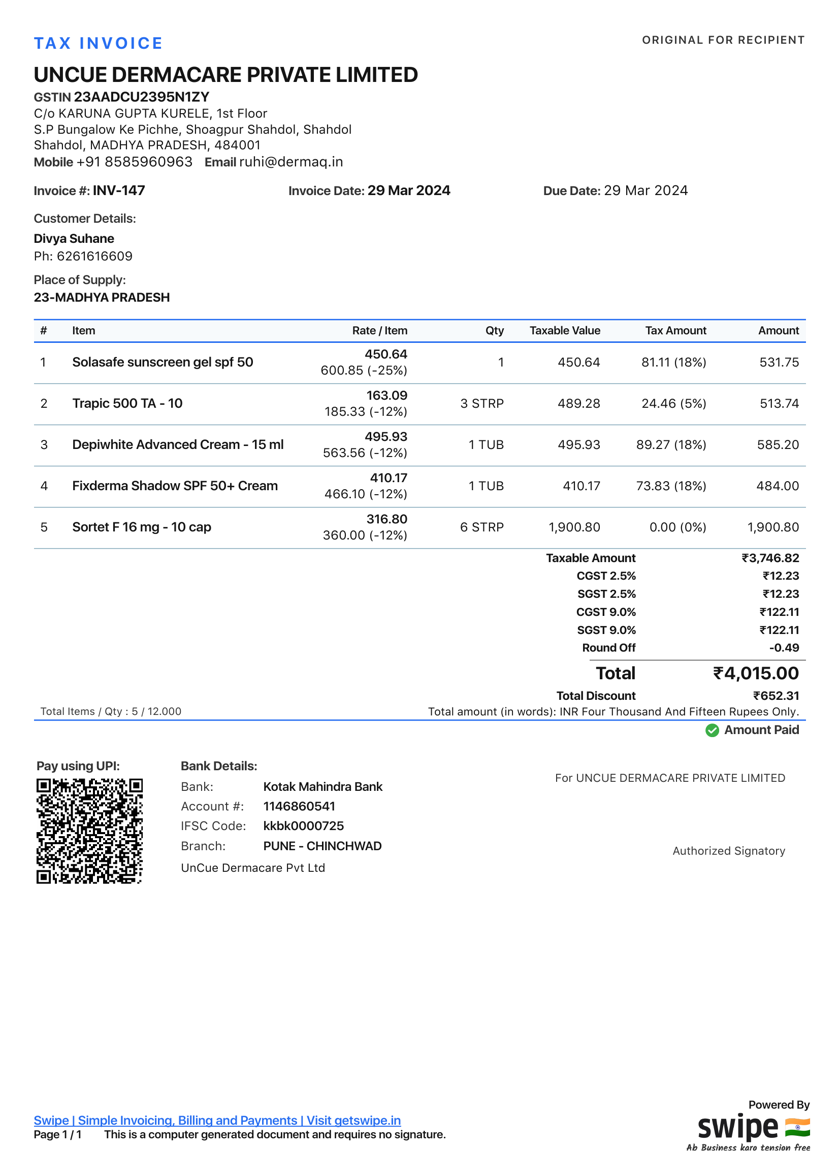

In [258]:
image_inputs[1]

In [163]:
llm_inputs[0]

{'prompt': '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>From the given invoice, extract the following information in json format : \nSupplier Details : Supplier Name , GSTIN No. , Address, Mobile No. , Email \nInvoice Details: Invoice No. , Invoice Date , Invoice Due Date\nCustomer Details: Customer Name , Place of Supply\nItem Details : Item no. , Item Name, Unit Price, Unit Price Discount, Quantity , Taxable Value, Tax Amount , Amount\nTotal Details : Total Taxable Amount , CGST, SGST , Roundoff, Total Amount to be paid , Total Discount\nBank Details : Bank Name, Account No, IFSC code, Branch Name\n<|im_end|>\n<|im_start|>assistant\n',
 'multi_modal_data': {'image': <PIL.Image.Image image mode=RGB size=28x28>}}

In [190]:
sampling_params = SamplingParams(
    temperature=0.1,
    top_p=0.001,
    repetition_penalty=1.05,
    max_tokens=2048,
    stop_token_ids=[],
)


<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>From the given invoice, extract the following information in json format : 
Supplier Details : Supplier Name , GSTIN No. , Address, Mobile No. , Email 
Invoice Details: Invoice No. , Invoice Date , Invoice Due Date
Customer Details: Customer Name , Place of Supply
Item Details : Item no. , Item Name, Unit Price, Unit Price Discount, Quantity , Taxable Value, Tax Amount , Amount
Total Details : Total Taxable Amount, Roundoff, Total Amount to be paid , Total Discount
CGST/SGST : Percentages , Amounts  (These are in a pair meaning in a pair CGST and SGST amount will be same but there may be many pairs of them)
Bank Details : Bank Name, Account No, IFSC code, Branch Name
<|im_end|>
<|im_start|>assistant



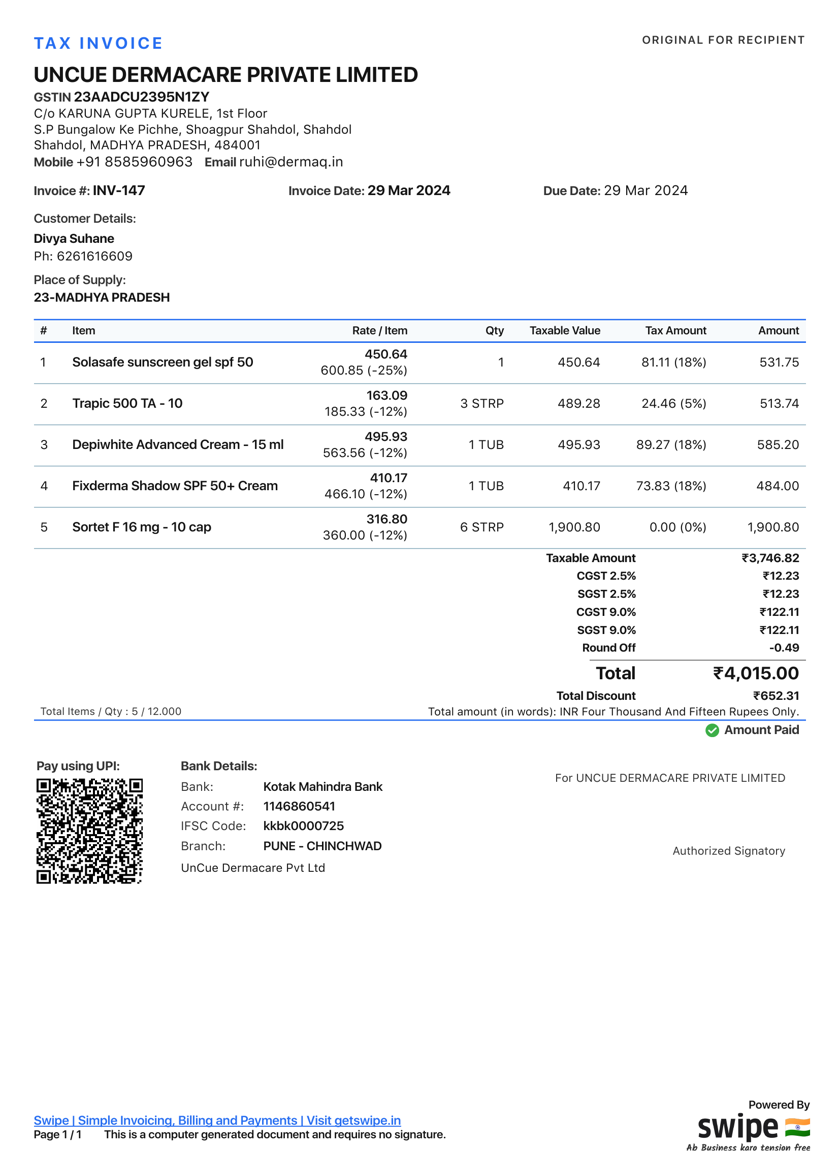

In [265]:
print(llm_inputs[1]['prompt'])
llm_inputs[1]['multi_modal_data']['image']

In [267]:
outputs = llm.generate(llm_inputs, sampling_params=sampling_params)
generated_text = outputs[0].outputs[0].text

print(generated_text)

Processed prompts: 100%|██████████| 24/24 [01:27<00:00,  3.66s/it, est. speed input: 394.03 toks/s, output: 188.96 toks/s]

```json
{
  "supplier_details": {
    "name": "UNCUE DERMACARE PRIVATE LIMITED",
    "gstin_no": "23AADCU2395N1ZY",
    "address": "C/o KARUNA GUPTA KURELE, 1st Floor S.P Bungalow Ke Pichhe, Shoagpur Shahdol, Shahdol Shahdol, MADHYA PRADESH, 484001",
    "mobile_no": "+91 8585960963",
    "email": "ruhi@dermaq.in"
  },
  "invoice_details": {
    "invoice_no": "INV-135",
    "invoice_date": "01 Mar 2024",
    "due_date": "01 Mar 2024"
  },
  "customer_details": {
    "name": "Mohith Saragur",
    "place_of_supply": "23-MADHYA PRADESH"
  },
  "item_details": [
    {
      "item_no": 1,
      "item_name": "Tab flucon 400mg",
      "unit_price": "22.58",
      "unit_price_discount": "-20%",
      "quantity": "3 STRP",
      "taxable_value": "67.75",
      "tax_amount": "12.19",
      "amount": "79.94"
    },
    {
      "item_no": 2,
      "item_name": "Lupizol ZS Shampoo 100 ml",
      "unit_price": "369.91",
      "unit_price_discount": "-12%",
      "quantity": "1 BTL",
      "taxable_v

In [271]:
import re
import json

def extract_json_from_string(text):
    # Regular expression to match the content between ```json and ```
    json_pattern = r"```json\s*(.*?)\s*```"
    
    # Find all JSON strings in the text
    matches = re.findall(json_pattern, text, re.DOTALL)

    # Parse and return the extracted JSON
    extracted_jsons = []
    for match in matches:
        try:
            # Try to load the JSON string
            json_data = json.loads(match)
            extracted_jsons.append(json_data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
    return extracted_jsons[0]


In [272]:
josn = []
outs_text = [i.outputs[0].text for i in outputs]
josn = [extract_json_from_string(i) for i in outs_text]

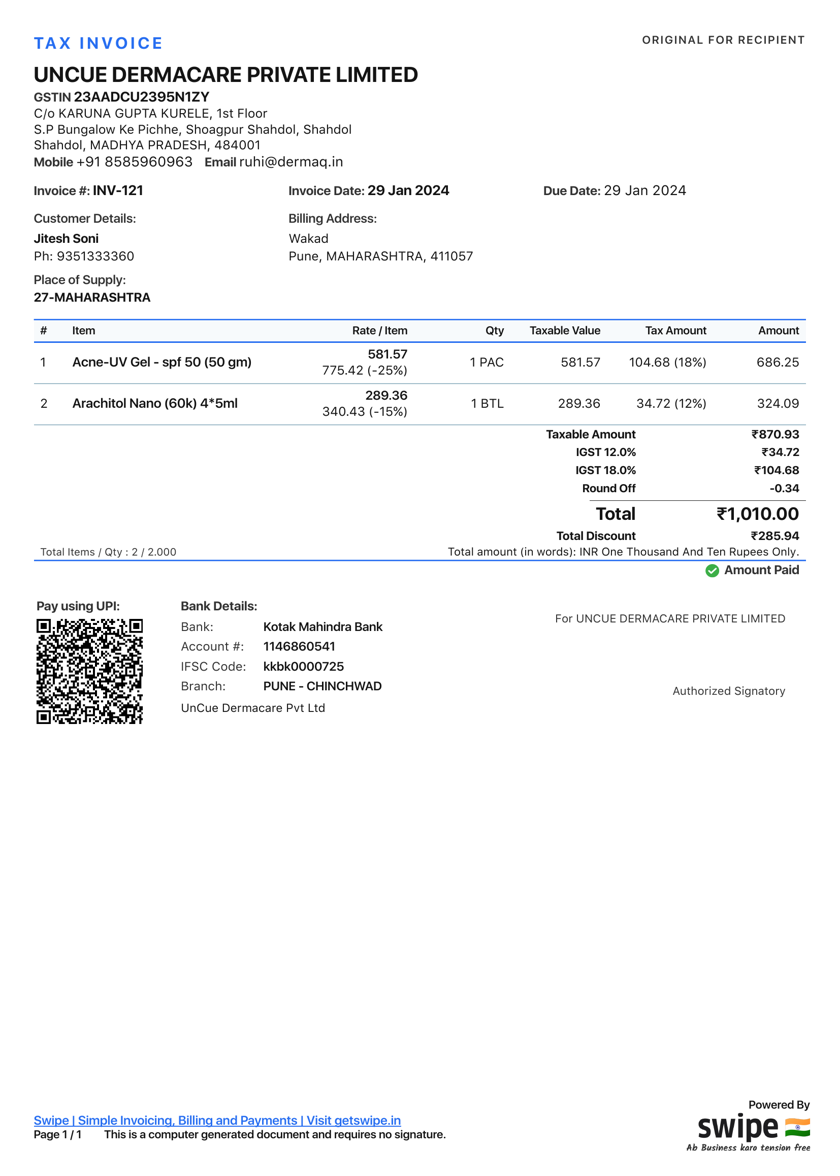

In [312]:
##COmparision with pdf images

llm_inputs[21]['multi_modal_data']['image']

In [279]:
josn[21]

{'supplier_details': {'name': 'UNCUE DERMACARE PRIVATE LIMITED',
  'gstin_no': '23AADCU2395N1ZY',
  'address': 'C/o KARUNA GUPTA KURELE, 1st Floor S.P Bungalow Ke Pichhe, Shoagpur Shahdol, Shahdol Shahdol, MADHYA PRADESH, 484001',
  'mobile_no': '+91 8585960963',
  'email': 'ruhi@dermaq.in'},
 'invoice_details': {'invoice_no': 'INV-121',
  'invoice_date': '29 Jan 2024',
  'due_date': '29 Jan 2024'},
 'customer_details': {'name': 'Jitesh Soni',
  'place_of_supply': '27-MAHARASHTRA'},
 'item_details': [{'item_no': 1,
   'item_name': 'Acne-UV Gel - spf 50 (50 gm)',
   'unit_price': '581.57',
   'unit_price_discount': '-25%',
   'quantity': '1 PAC',
   'taxable_value': '581.57',
   'tax_amount': '104.68',
   'amount': '686.25'},
  {'item_no': 2,
   'item_name': 'Arachitol Nano (60k) 4*5ml',
   'unit_price': '289.36',
   'unit_price_discount': '-15%',
   'quantity': '1 BTL',
   'taxable_value': '289.36',
   'tax_amount': '34.72',
   'amount': '324.09'}],
 'total_details': {'taxable_amount':

In [303]:
import pickle


# Convert the paths_order to a pickle file
with open('paths_order.pkl', 'wb') as file:
    pickle.dump(img_paths, file)
# Convert the json_qwen_vlm to a pickle file
with open('json_qwen_vlm.pkl', 'wb') as file:
    pickle.dump(josn, file)
